# Number 3: Columns Joins 

You have two datasets:

* An Excel document of obesity rates, called `obesity.xlsx`
* A shapefile of US states from the [Census Burea](https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html), unzipped into `cb_2016_us_state_500k/`

You're going to make a choropleth of obesity rates in US states.

**MAKE SURE YOU HAVE COMPLETED PART TWO BEFORE YOU DO THIS ONE.**

## Part Zero: Import what you need

I'm not giving you any more hints!

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

In [2]:
states = gpd.read_file("cb_2016_us_state_500k/cb_2016_us_state_500k.shp")

In [3]:
obesity = pd.read_excel("obesity.xlsx")

## Part One: Opening your datasets

**Open up both files!** Think about what kind of file each one is before you try to open it.

In [4]:
obesity.head()

,statename,pct
0,Alabama,31.1
1,Alaska,27.7
2,Arizona,24.4
3,Arkansas,33.2
4,California,22.2


## Part Two: Map the states, just for fun

To double-check that the states look okay, make a quick map of them.

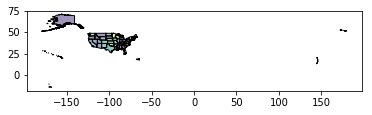

In [5]:
states.plot()

Uh, well, let's just stick to the continental Uninted States for now. An easy way to do this is by creating a **bounding box** and filtering out the ones that aren't inside.

I like to use [this dumb site](https://itouchmap.com/latlong.html) to find the latitude and longitude of specific points, but if I'm just trying to figure out a box I use [geojson.io](http://geojson.io/) and just... draw a box and see what it tells me.

For example, down below I am only selecting **the northeast**. I got the boundaries by drawing a box on geojson.io. We also use our good friend **`.within`** from last time to say hey states, which ones of you are inside of the boundary box?

In [6]:
from shapely.geometry import Polygon

bounds = [
            [
              -80.68359375,
              37.75334401310656
            ],
            [
              -65.91796875,
              37.75334401310656
            ],
            [
              -65.91796875,
              48.37084770238366
            ],
            [
              -80.68359375,
              48.37084770238366
            ],
            [
              -80.68359375,
              37.75334401310656
            ]
]

# Turn the coordinates into a shapely polygon
northeast_box = Polygon(bounds)

# Make sure our state CRS is in lat/lng by using to_crs
# You could also just have done
# states = states.to_crs({'init': 'epsg:4326'})
# and converted it permanently once instead of doing it multiple times later on
states.to_crs({'init': 'epsg:4326'}).within(northeast_box).head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6     True
7     True
8     True
9    False
dtype: bool

And of course we can take those `True` and `False` values and feed them back into `states` to only get the states we're interested in. I plot them below, but you could always save them to a variable instead!

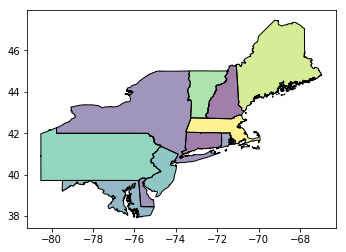

In [8]:
states[states.to_crs({'init': 'epsg:4326'}).within(northeast_box)].plot()

## Part Three: Filter your states

So *I* selected only states in the northeast. Now it's your job to use that new skill to **filter out any states that aren't in the continental USA.**

In [9]:
bounds_usa = [
            [
              -126.12304687500001,
              49.89463439573421
            ],
            [
              -126.12304687500001,
              23.805449612314625
            ],
            [
              -65.390625,
              24.44714958973082
            ],
            [
              -65.126953125,
              50.401515322782366
            ],
            [
              -126.12304687500001,
              49.89463439573421
            ]
          ]

usa_box = Polygon(bounds_usa)
states.to_crs({'init': 'epsg:4326'}).within(usa_box).head(10)

0     True
1    False
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
dtype: bool

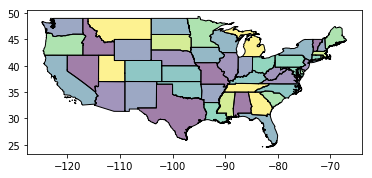

In [10]:
states[states.to_crs({'init': 'epsg:4326'}).within(usa_box)].plot()

In [26]:
states = states[states.within(usa_box)]

## Part Four: Joining your data

You have some obesity data, it looks like this:

In [11]:
obesity.head(3)

,statename,pct
0,Alabama,31.1
1,Alaska,27.7
2,Arizona,24.4


You have some states, they look like this:

In [27]:
states.head(3)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry,pct_x,pct_y
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999...",31.1,31.1
2,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3...",24.4,24.4
3,0400000US05,134771517596,2960191698,05,00,Arkansas,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ...",33.2,33.2


You need to **merge them together** using [merge](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html), which is just a normal pandas thing we've done before.

**THIS IS NOT A SPATIAL JOIN.** We're just saying hey, you guys both have columns that match, right? You might want to get together.

All `.merge` needs is two dataframes and a `left_on`/`right_on` to specify which columns to match up. Unlike a spatial join, for most column joins it doesn't matter which one is "left" and which one is "right."

In [14]:
obesity = obesity.rename(columns={'statename':'NAME'})

In [28]:
states = states.merge(obesity, how='left', on='NAME')
states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry,pct_x,pct_y,pct
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999...",31.1,31.1,31.1
1,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3...",24.4,24.4,24.4
2,0400000US05,134771517596,2960191698,05,00,Arkansas,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ...",33.2,33.2,33.2
3,0400000US06,403501101370,20466718403,06,00,California,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ...",22.2,22.2,22.2
4,0400000US08,268429343790,1175112870,08,00,Colorado,08,01779779,CO,"POLYGON ((-109.060253 38.599328, -109.059541 3...",19.1,19.1,19.1


## Part Five: Mapping your data

Map it. Familiar projection, nice large size, etc. Use a [nice color map](https://matplotlib.org/examples/color/colormaps_reference.html) that makes sense.

The one below is Mercator - you can see the grumpy top of the USA - see if you can make it something better! Maybe find the EPSG code for an Albers Equal Area that's good for the continental United States?

In [29]:
states = gpd.GeoDataFrame(states)

In [41]:
states.crs = {'init': 'epsg:4326'}

NotImplementedError: 

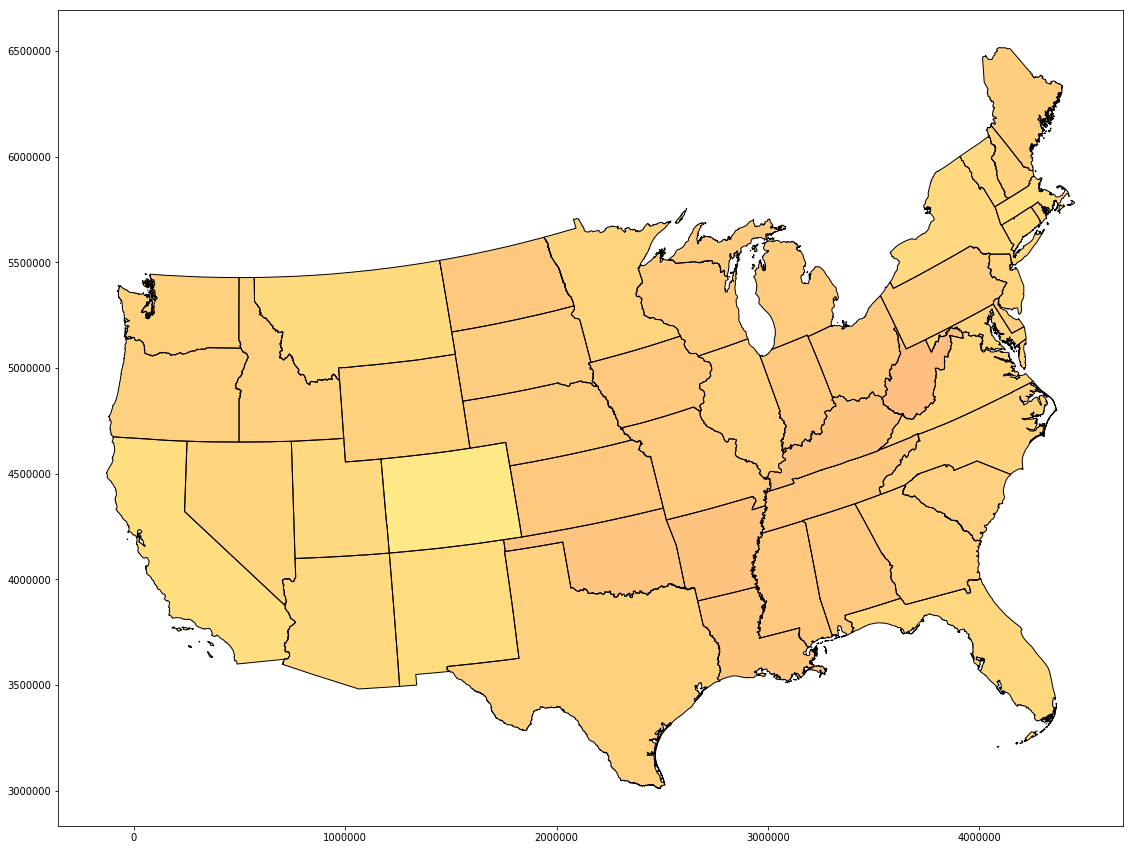

In [44]:
ax = states.to_crs(epsg=2955).plot(figsize=(40,15), column='pct_x', legend=True, cmap='Wistia')
ax.axis('off')

To get a different look, try passing `legend=True` and `scheme='Quantiles'`.

(-357621.81753608421,
 4678700.4957008241,
 2834493.4671854316,
 6691239.7245244766)

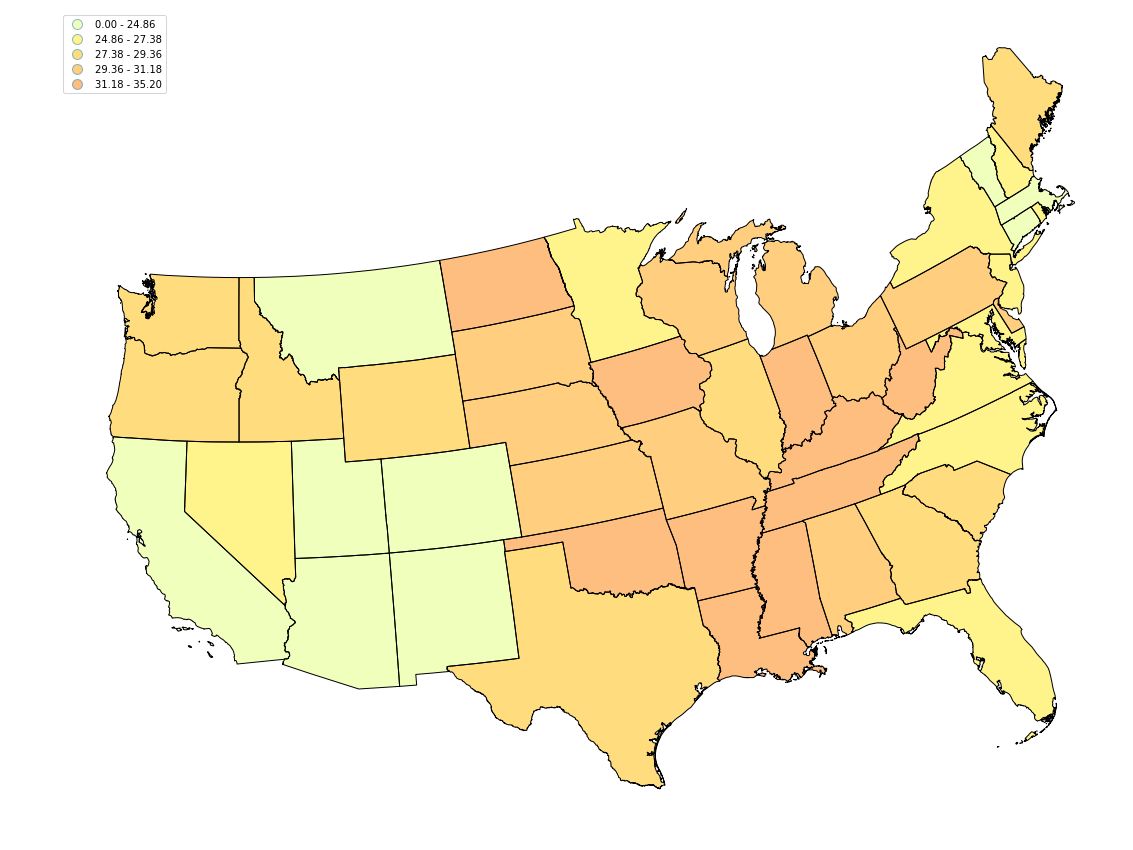

In [46]:
ax = states.to_crs(epsg=2955).plot(figsize=(40,15), column='pct_x', scheme='quantiles', legend=True, cmap='Wistia')
ax.axis('off')

And oooone more time with `legend=True` and `scheme='equal_interval'`

(-357621.81753608421,
 4678700.4957008241,
 2834493.4671854316,
 6691239.7245244766)

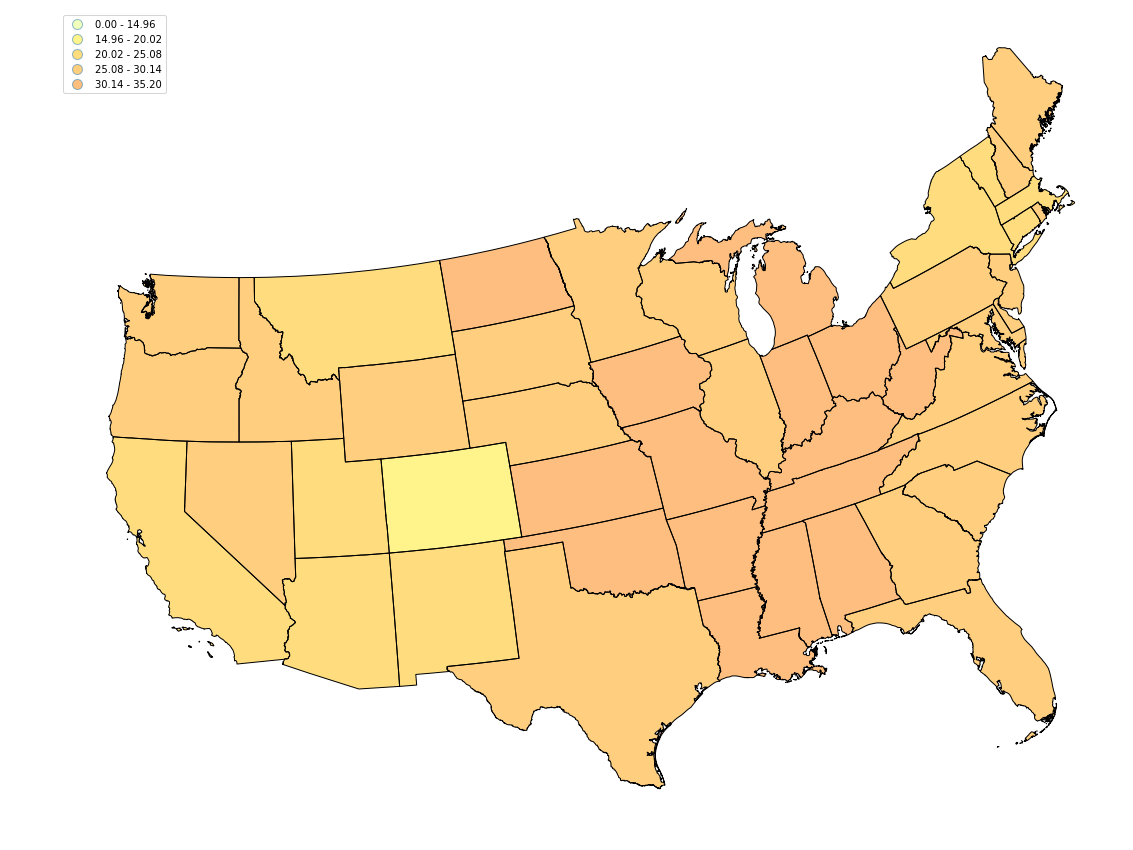

In [47]:
ax = states.to_crs(epsg=2955).plot(figsize=(40,15), column='pct_x', scheme='equal_interval', legend=True, cmap='Wistia')
ax.axis('off')

## Think about which one does the best job telling the story.

We'll talk about this next class.